# **1. Perkenalan Dataset**


# **2. Import Library**

In [21]:
#Type your code here
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# from sklearn.preprocessing import StandardScaler
# from imblearn.over_sampling import SMOTE

# **3. Memuat Dataset**

In [22]:
#Type your code here
df = pd.read_csv('data.csv')

In [23]:
df

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,...,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,...,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,...,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,...,4,80,0,17,3,2,9,6,0,8


# 4 EDA

Dataset Shape: (1470, 35)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-nu

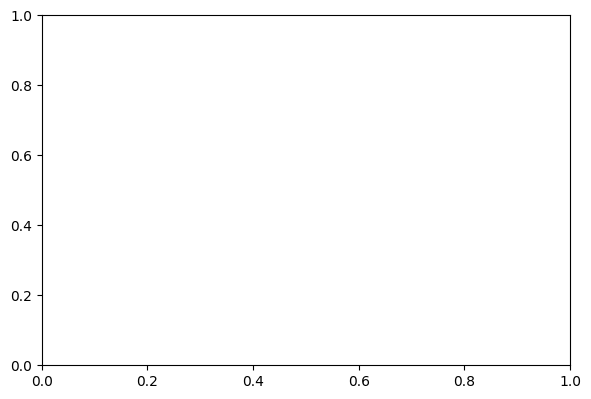

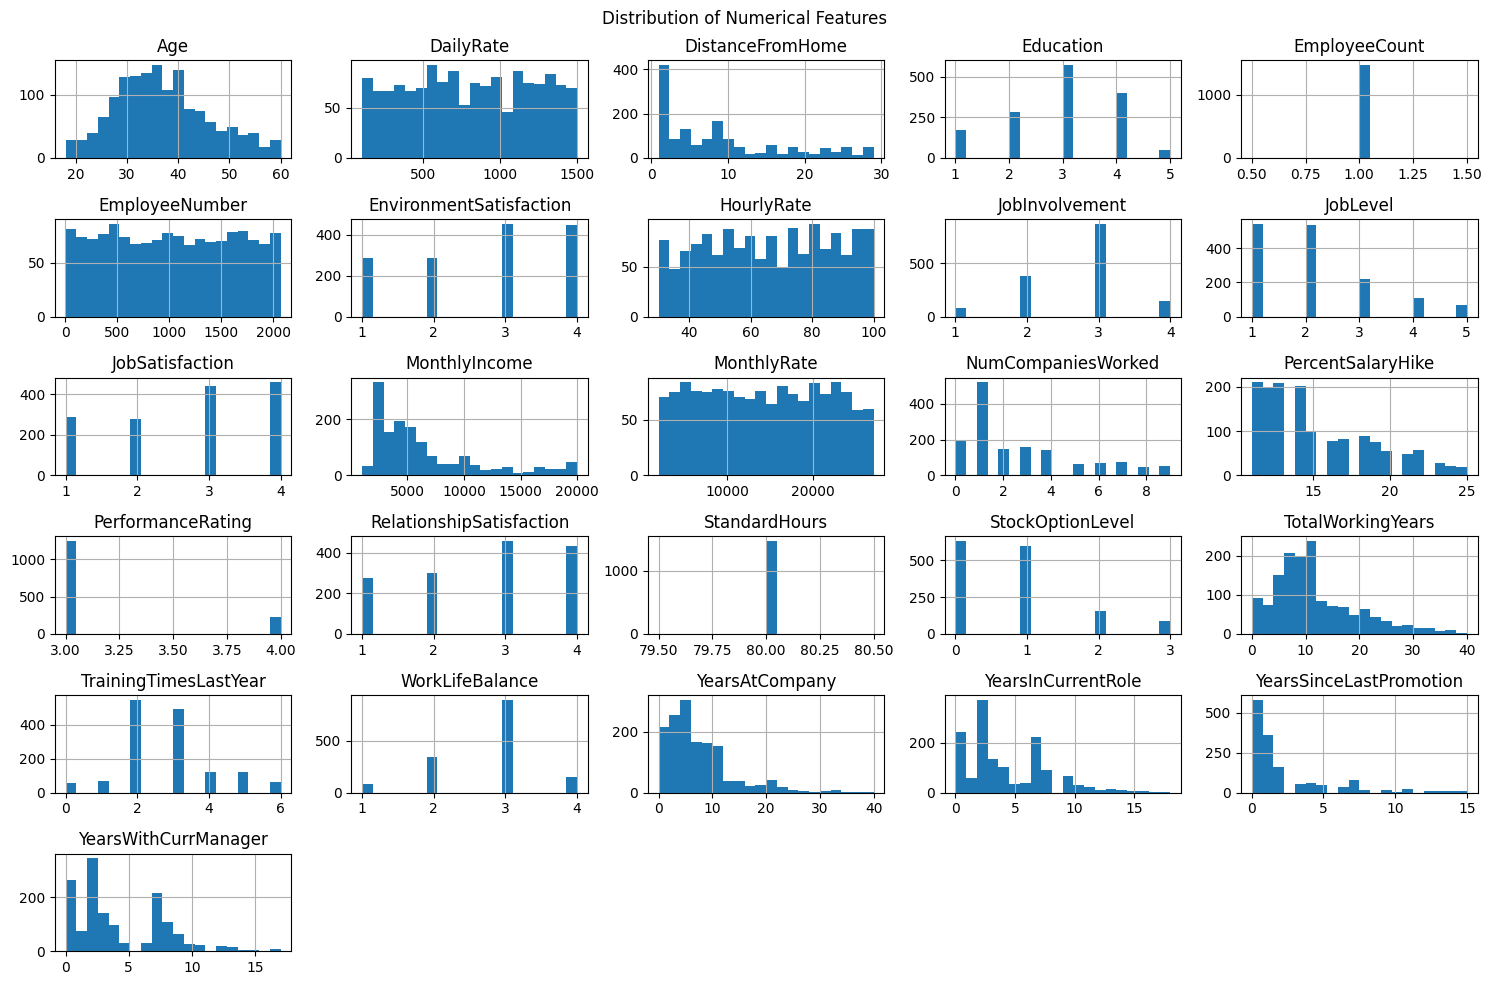

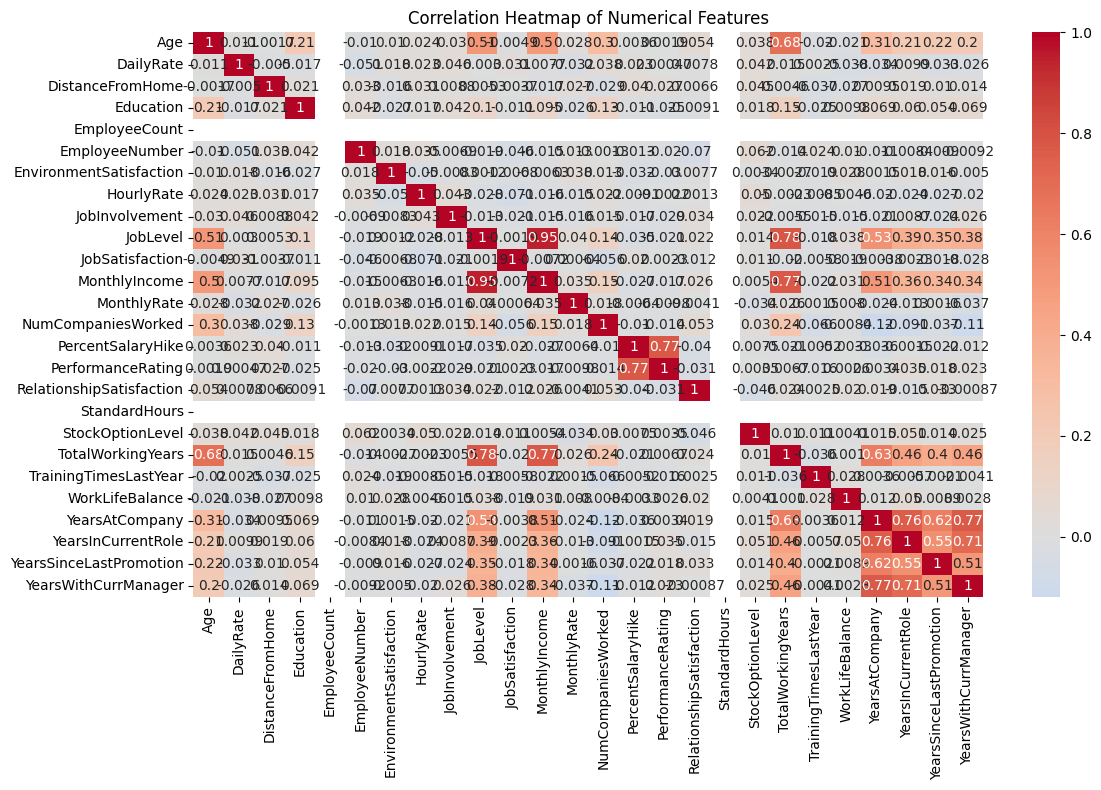

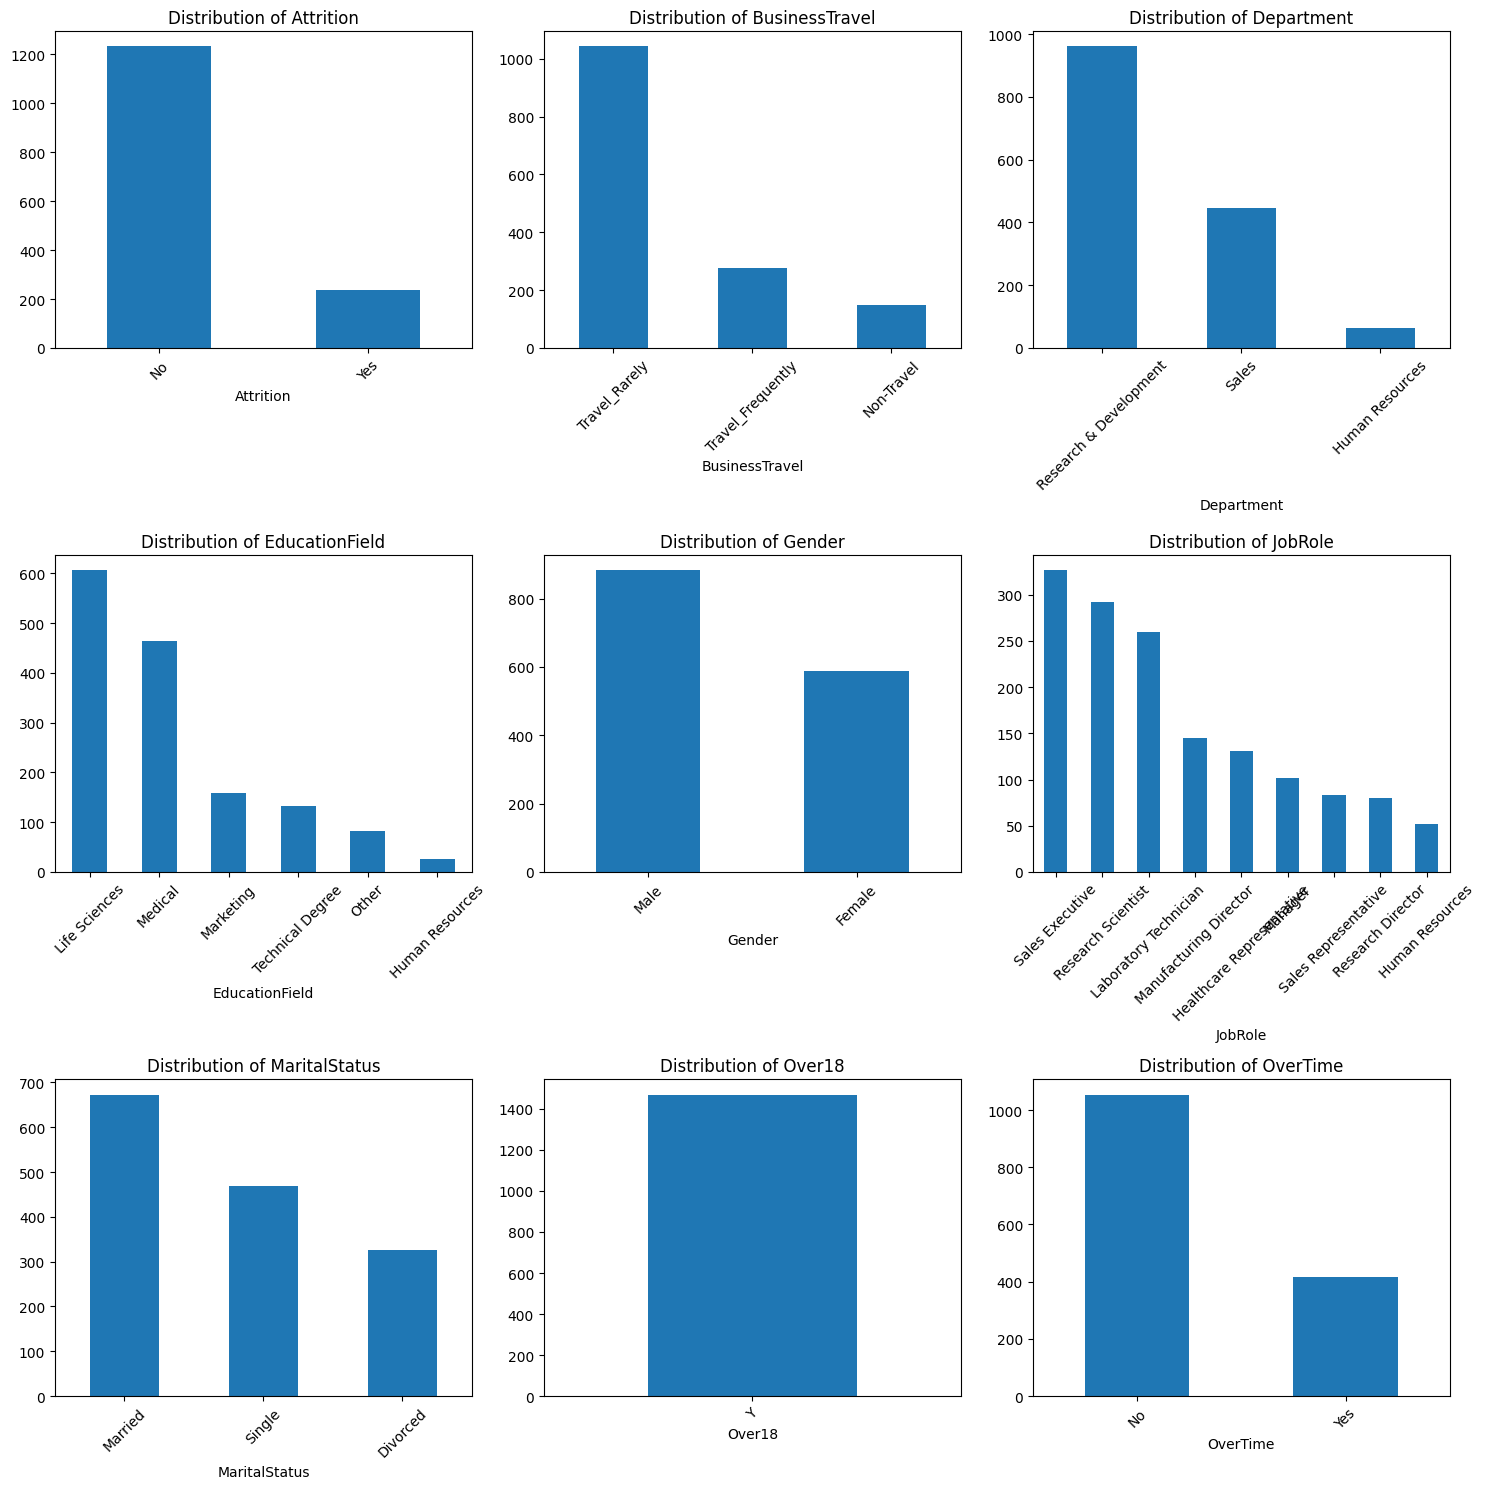

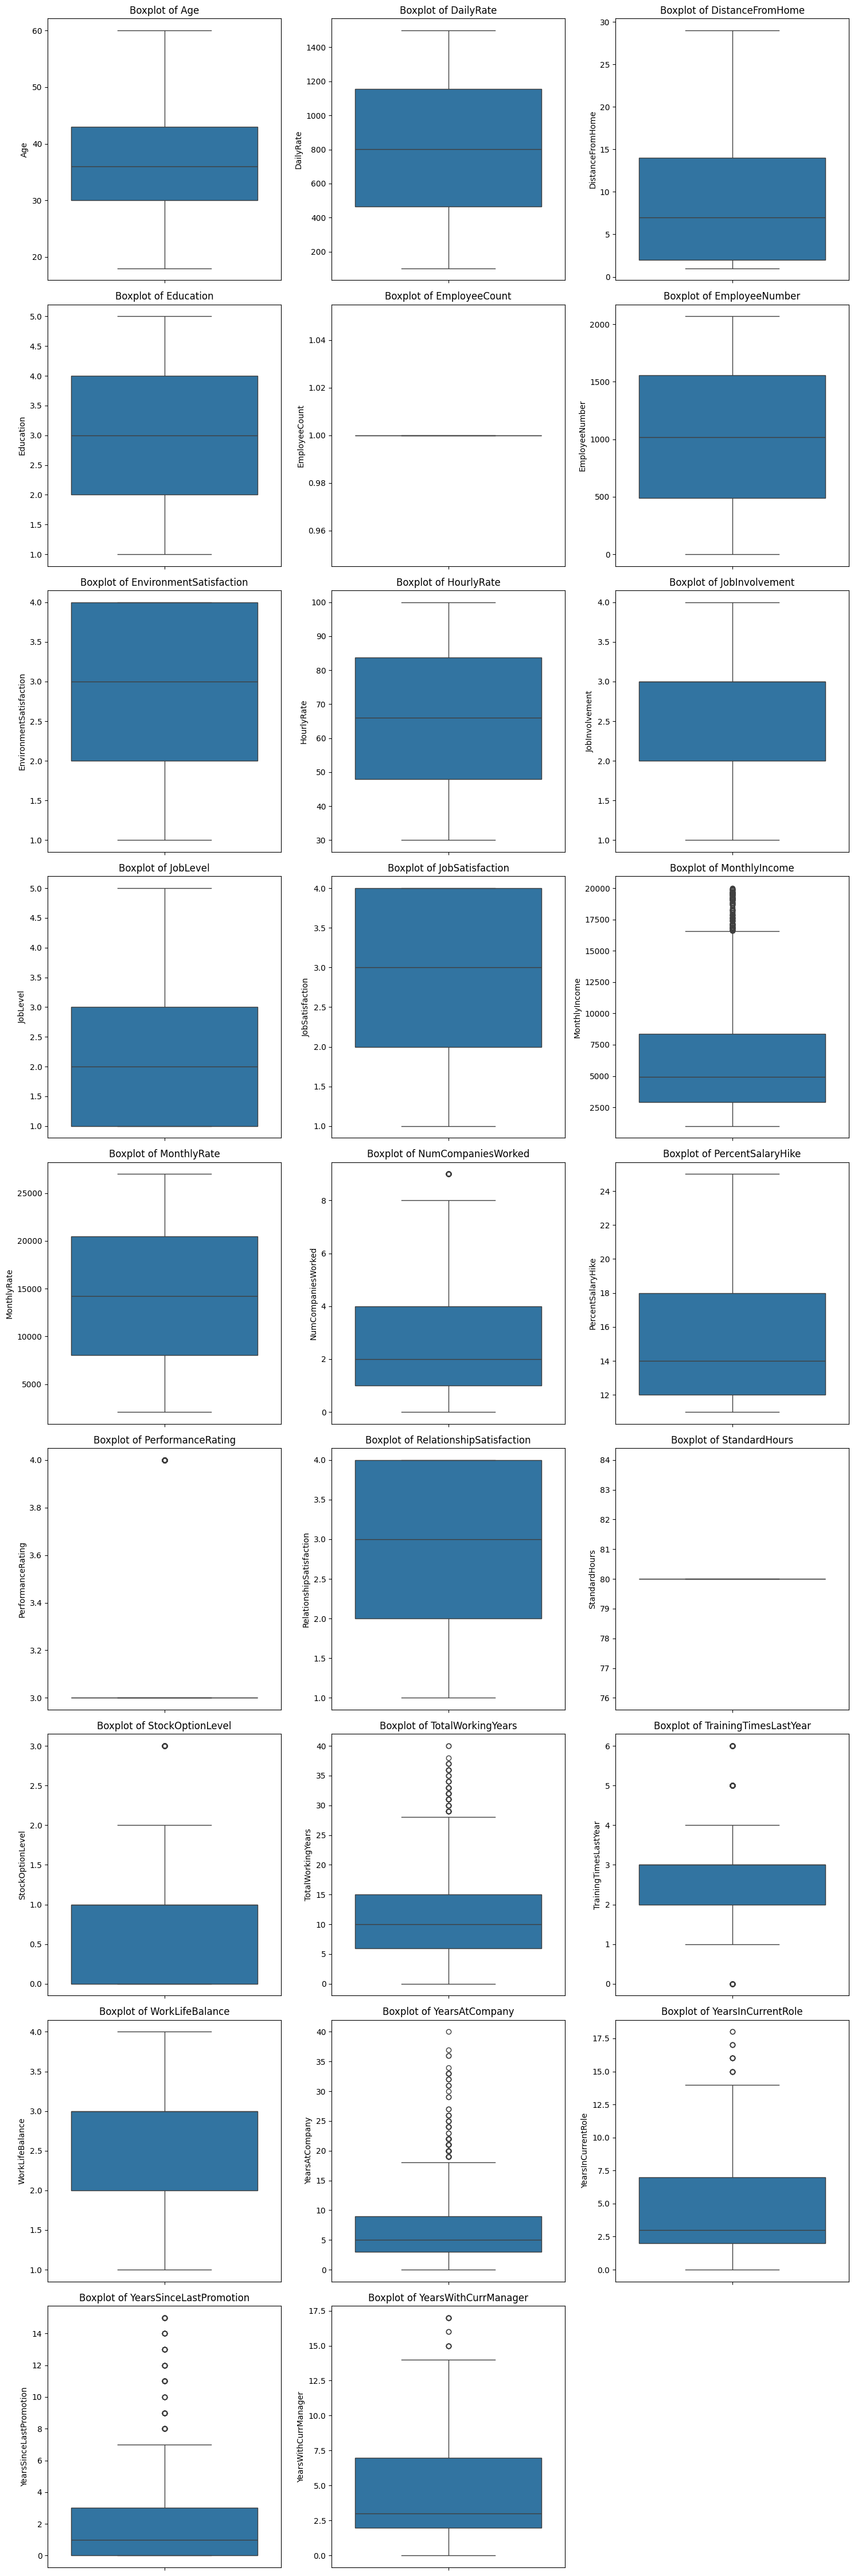

In [24]:
# Basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
df.info()

print("\nFirst 5 rows:")
df.head()

print("\nLast 5 rows:")
df.tail()

print("\nDataset Description:")
df.describe()

print("\nMissing Values:")
print(df.isnull().sum())

print("\nData Types:")
print(df.dtypes)

print("\nUnique values in each column:")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")

# Check for duplicates
print(f"\nDuplicate rows: {df.duplicated().sum()}")

# Visualizations
plt.figure(figsize=(15, 10))

# Distribution of numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
if len(numerical_cols) > 0:
    plt.subplot(2, 2, 1)
    df[numerical_cols].hist(bins=20, figsize=(15, 10))
    plt.suptitle('Distribution of Numerical Features')
    plt.tight_layout()

# Correlation heatmap for numerical features
if len(numerical_cols) > 1:
    plt.figure(figsize=(12, 8))
    correlation_matrix = df[numerical_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Heatmap of Numerical Features')
    plt.tight_layout()
    plt.show()

# Distribution of categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
if len(categorical_cols) > 0:
    fig, axes = plt.subplots(nrows=(len(categorical_cols)+2)//3, ncols=3, figsize=(15, 5*((len(categorical_cols)+2)//3)))
    axes = axes.flatten() if len(categorical_cols) > 3 else [axes] if len(categorical_cols) == 1 else axes
    
    for i, col in enumerate(categorical_cols):
        if i < len(axes):
            df[col].value_counts().plot(kind='bar', ax=axes[i])
            axes[i].set_title(f'Distribution of {col}')
            axes[i].tick_params(axis='x', rotation=45)
    
    # Hide unused subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Check for outliers using boxplots
if len(numerical_cols) > 0:
    fig, axes = plt.subplots(nrows=(len(numerical_cols)+2)//3, ncols=3, figsize=(15, 5*((len(numerical_cols)+2)//3)))
    axes = axes.flatten() if len(numerical_cols) > 3 else [axes] if len(numerical_cols) == 1 else axes
    
    for i, col in enumerate(numerical_cols):
        if i < len(axes):
            sns.boxplot(y=df[col], ax=axes[i])
            axes[i].set_title(f'Boxplot of {col}')
    
    # Hide unused subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

=== ANALISIS HUBUNGAN ANTAR VARIABEL KATEGORIKAL ===



C:\Users\Swift GO 14\AppData\Local\Temp\ipykernel_50000\3830831646.py:23: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
C:\Users\Swift GO 14\AppData\Local\Temp\ipykernel_50000\3830831646.py:23: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
C:\Users\Swift GO 14\AppData\Local\Temp\ipykernel_50000\3830831646.py:23: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
C:\Users\Swift GO 14\AppData\Local\Temp\ipykernel_50000\3830831646.py:23: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
C:\Users\Swift GO 14\AppData\Local\Temp\ipykernel_50000\3830831646.py:23: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
C:\Users\Swift GO 14\AppData\Local\Temp\ipykernel_50000\3830

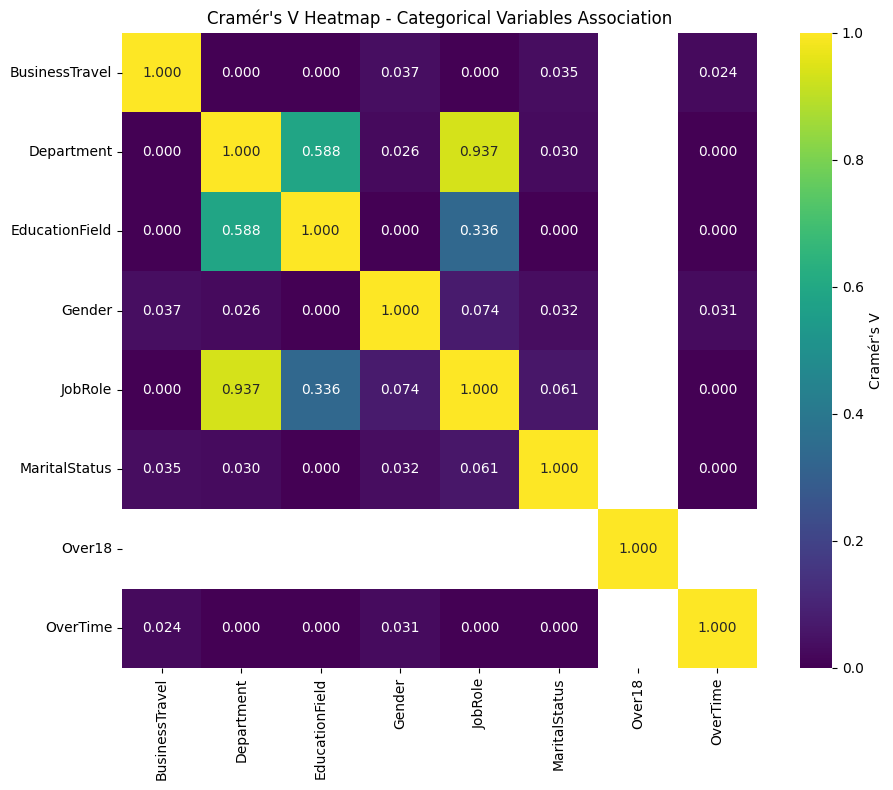

Pasangan variabel dengan asosiasi kuat (Cramér's V > 0.3):
------------------------------------------------------------
Department vs EducationField: Cramér's V = 0.588
Department vs JobRole: Cramér's V = 0.937
EducationField vs JobRole: Cramér's V = 0.336


Visualisasi 3 asosiasi terkuat:


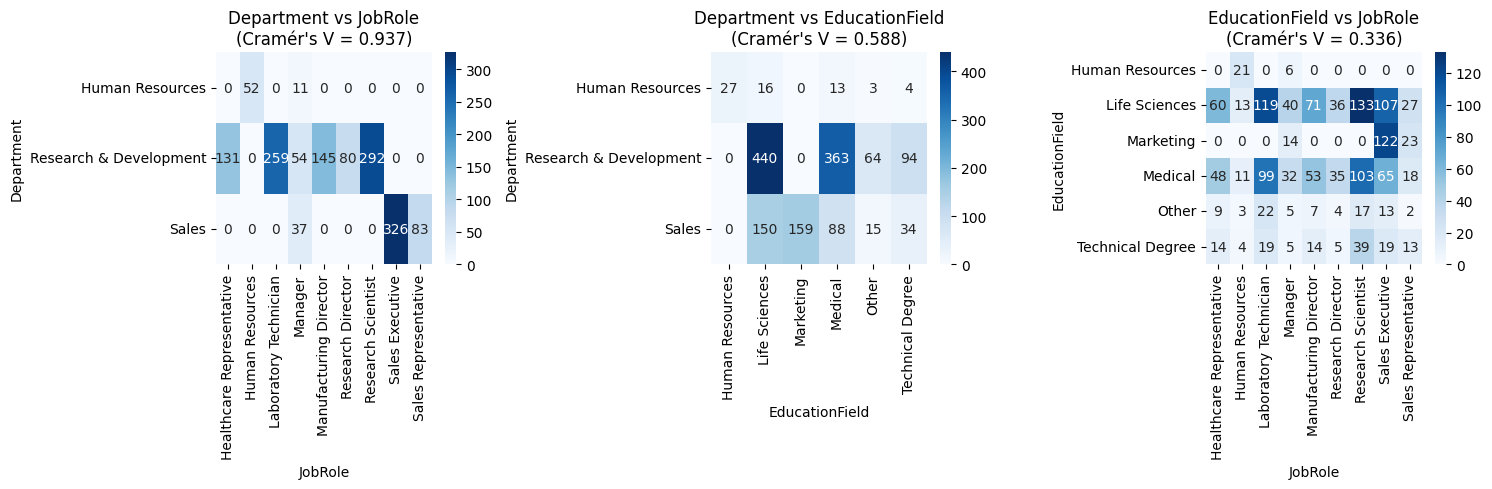

In [25]:
# 2. Analisis Hubungan Antar Variabel Kategorikal (Selain Target)

# Get categorical columns excluding the target variable
categorical_cols_analysis = [col for col in categorical_cols if col != 'Attrition']

if len(categorical_cols_analysis) > 1:
    print("=== ANALISIS HUBUNGAN ANTAR VARIABEL KATEGORIKAL ===\n")
    
    # Chi-square test for independence between categorical variables
    from scipy.stats import chi2_contingency
    
    # Create a correlation-like matrix for categorical variables using Cramér's V
    def cramers_v(x, y):
        """Calculate Cramér's V statistic for categorical-categorical association"""
        confusion_matrix = pd.crosstab(x, y)
        chi2 = chi2_contingency(confusion_matrix)[0]
        n = confusion_matrix.sum().sum()
        phi2 = chi2 / n
        r, k = confusion_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
    
    # Calculate Cramér's V matrix
    cramers_matrix = pd.DataFrame(index=categorical_cols_analysis, columns=categorical_cols_analysis)
    
    for col1 in categorical_cols_analysis:
        for col2 in categorical_cols_analysis:
            if col1 == col2:
                cramers_matrix.loc[col1, col2] = 1.0
            else:
                cramers_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])
    
    # Convert to numeric
    cramers_matrix = cramers_matrix.astype(float)
    
    # Plot Cramér's V heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cramers_matrix, annot=True, cmap='viridis', center=0.5, 
                fmt='.3f', square=True, cbar_kws={'label': "Cramér's V"})
    plt.title("Cramér's V Heatmap - Categorical Variables Association")
    plt.tight_layout()
    plt.show()
    
    # Detailed analysis of strong associations (Cramér's V > 0.3)
    print("Pasangan variabel dengan asosiasi kuat (Cramér's V > 0.3):")
    print("-" * 60)
    
    strong_associations = []
    for i, col1 in enumerate(categorical_cols_analysis):
        for j, col2 in enumerate(categorical_cols_analysis):
            if i < j:  # Avoid duplicates
                cramers_val = cramers_matrix.loc[col1, col2]
                if cramers_val > 0.3:
                    strong_associations.append((col1, col2, cramers_val))
                    print(f"{col1} vs {col2}: Cramér's V = {cramers_val:.3f}")
    
    if not strong_associations:
        print("Tidak ada pasangan variabel dengan asosiasi kuat (Cramér's V > 0.3)")
    
    print("\n" + "="*60)
    
    # Visualize relationships for the strongest associations
    if strong_associations:
        # Sort by Cramér's V and take top 6
        strong_associations.sort(key=lambda x: x[2], reverse=True)
        top_associations = strong_associations[:6]
        
        print(f"\nVisualisasi {len(top_associations)} asosiasi terkuat:")
        
        fig, axes = plt.subplots(nrows=(len(top_associations)+2)//3, ncols=3, 
                                figsize=(15, 5*((len(top_associations)+2)//3)))
        if len(top_associations) == 1:
            axes = [axes]
        elif len(top_associations) <= 3:
            axes = axes if isinstance(axes, (list, np.ndarray)) else [axes]
        else:
            axes = axes.flatten()
        
        for i, (col1, col2, cramers_val) in enumerate(top_associations):
            if i < len(axes):
                # Create contingency table
                ct = pd.crosstab(df[col1], df[col2])
                
                # Create heatmap of the contingency table
                sns.heatmap(ct, annot=True, fmt='d', cmap='Blues', ax=axes[i])
                axes[i].set_title(f'{col1} vs {col2}\n(Cramér\'s V = {cramers_val:.3f})')
                axes[i].set_xlabel(col2)
                axes[i].set_ylabel(col1)
        
        # Hide unused subplots
        for j in range(len(top_associations), len(axes)):
            axes[j].set_visible(False)
        
        plt.tight_layout()
        plt.show()

else:
    print("Tidak cukup variabel kategorikal untuk analisis hubungan (minimum 2 variabel dibutuhkan)")


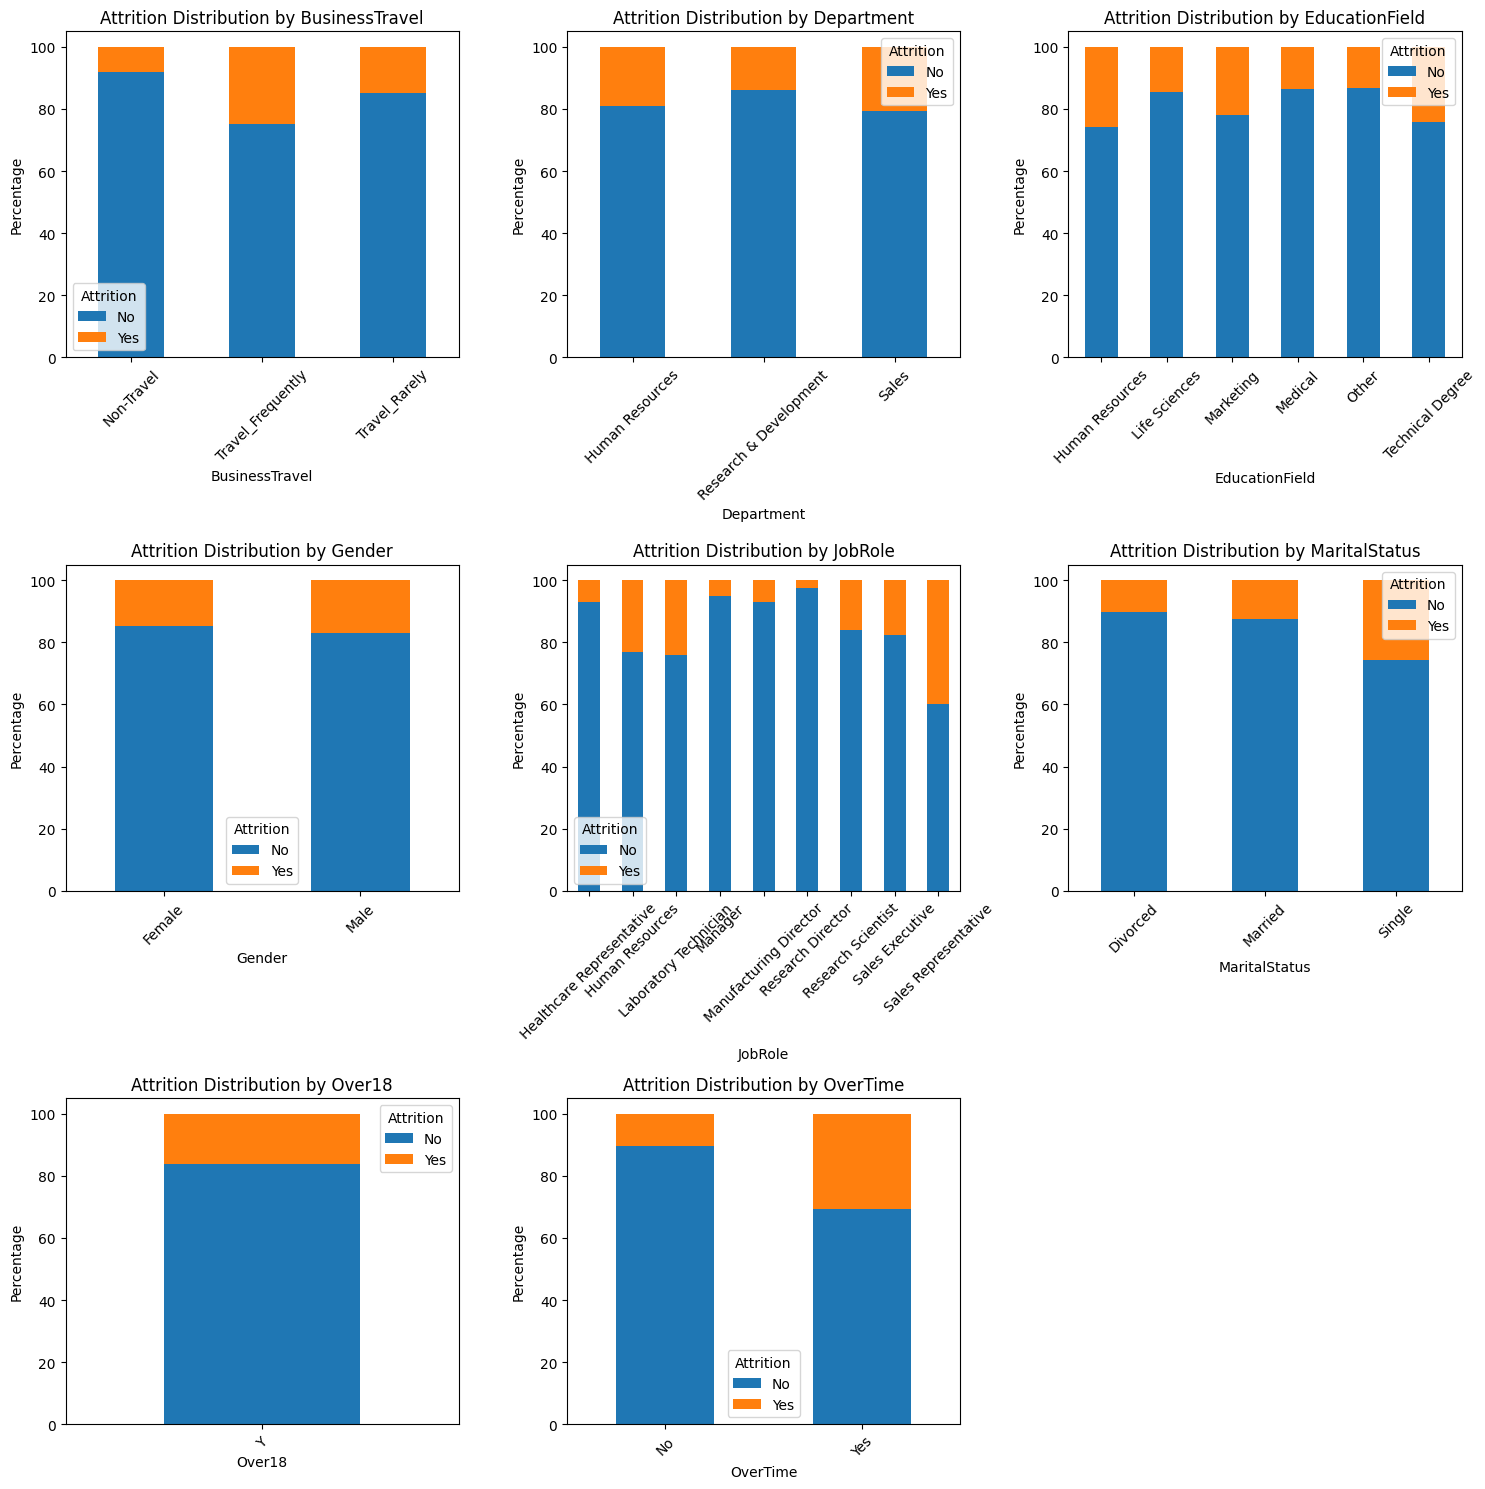

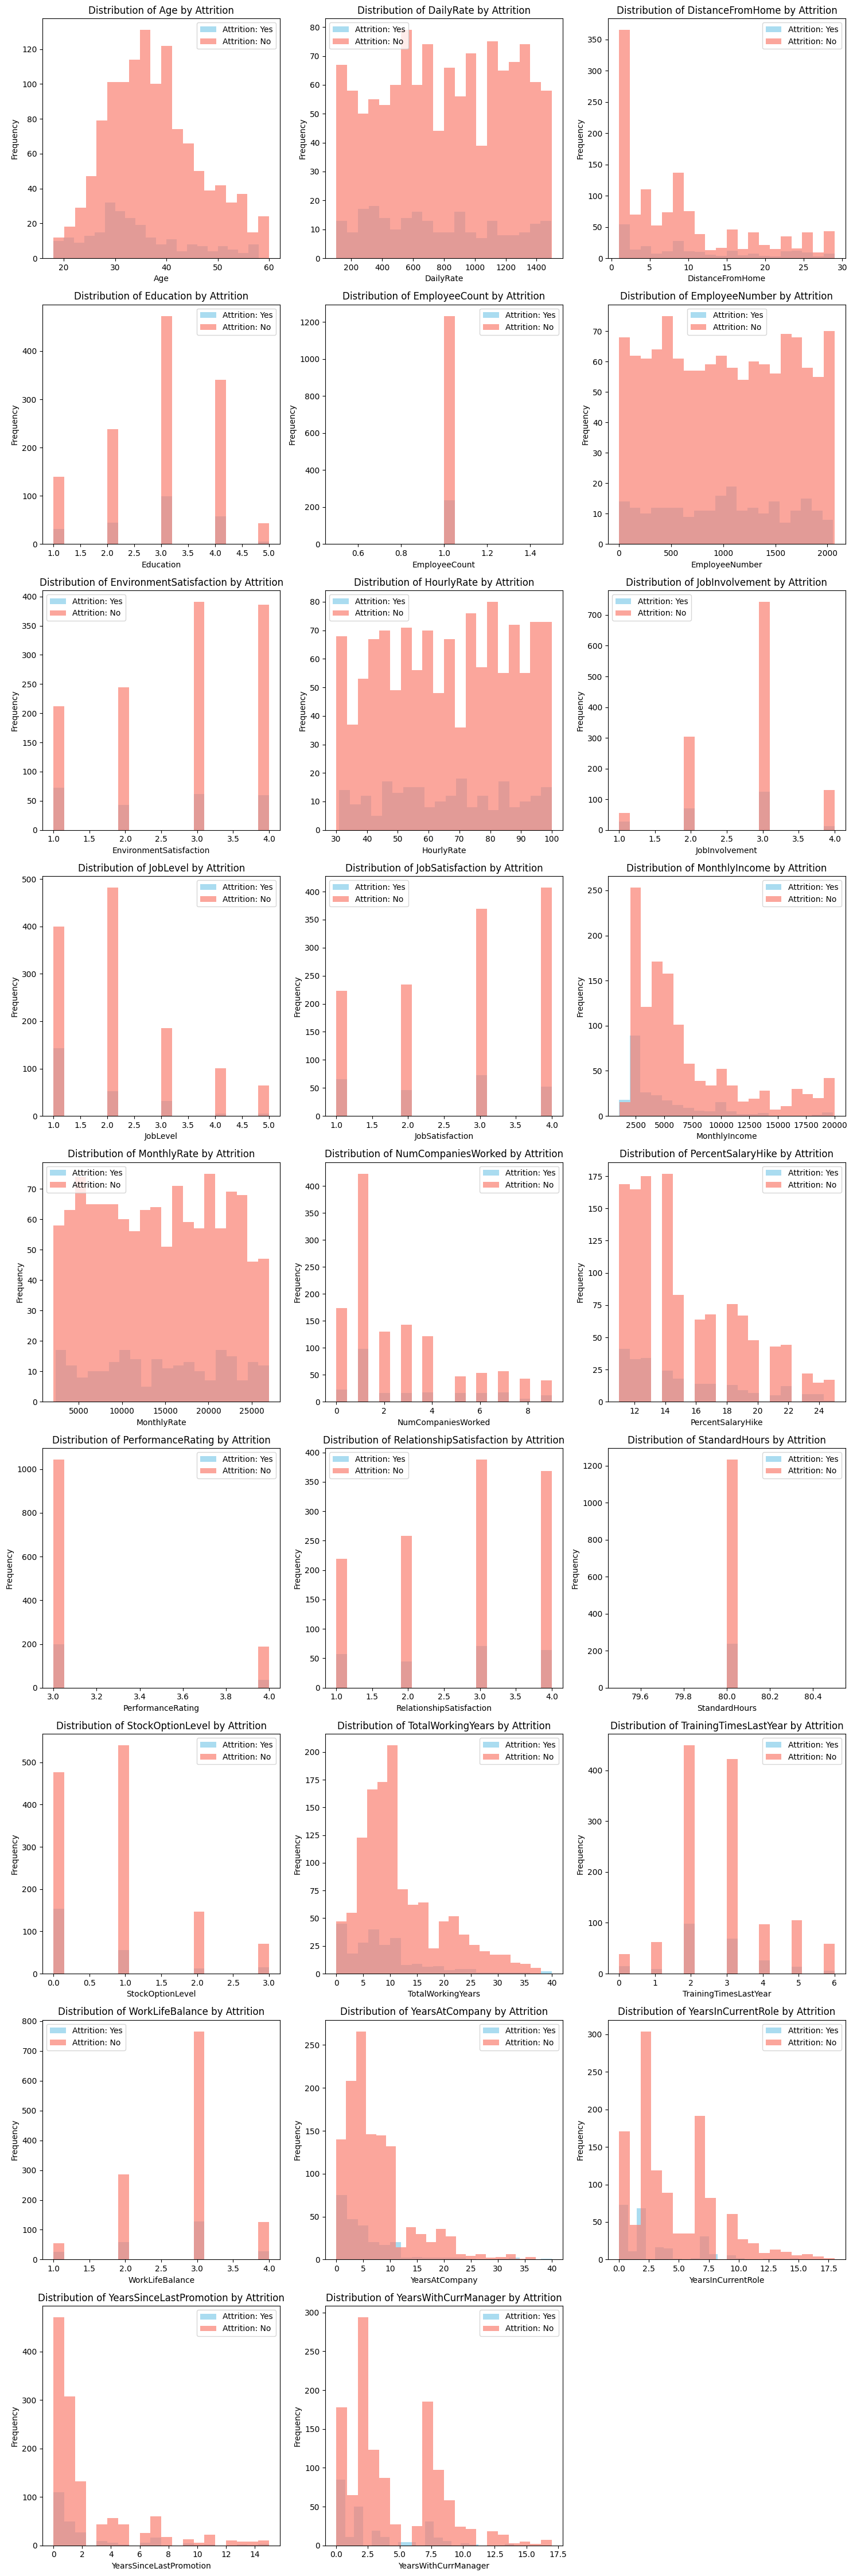

In [26]:
# Distribution of target variable (Attrition) across categorical features
categorical_cols = df.select_dtypes(include=['object']).columns
categorical_cols = [col for col in categorical_cols if col != 'Attrition']  # Exclude target variable

if len(categorical_cols) > 0:
    fig, axes = plt.subplots(nrows=(len(categorical_cols)+2)//3, ncols=3, figsize=(15, 5*((len(categorical_cols)+2)//3)))
    axes = axes.flatten() if len(categorical_cols) > 3 else [axes] if len(categorical_cols) == 1 else axes
    
    for i, col in enumerate(categorical_cols):
        if i < len(axes):
            # Create crosstab for better visualization
            ct = pd.crosstab(df[col], df['Attrition'], normalize='index') * 100
            ct.plot(kind='bar', ax=axes[i], stacked=True)
            axes[i].set_title(f'Attrition Distribution by {col}')
            axes[i].set_ylabel('Percentage')
            axes[i].tick_params(axis='x', rotation=45)
            axes[i].legend(title='Attrition')
    
    # Hide unused subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Distribution of target variable (Attrition) across numerical features
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

if len(numerical_cols) > 0:
    fig, axes = plt.subplots(nrows=(len(numerical_cols)+2)//3, ncols=3, figsize=(15, 5*((len(numerical_cols)+2)//3)))
    axes = axes.flatten() if len(numerical_cols) > 3 else [axes] if len(numerical_cols) == 1 else axes
    
    # Define consistent colors for attrition groups
    colors = ['skyblue', 'salmon']
    
    for i, col in enumerate(numerical_cols):
        if i < len(axes):
            # Create histogram for each attrition group
            for j, attrition_val in enumerate(df['Attrition'].unique()):
                subset = df[df['Attrition'] == attrition_val]
                axes[i].hist(subset[col], alpha=0.7, label=f'Attrition: {attrition_val}', bins=20, color=colors[j])
            
            axes[i].set_title(f'Distribution of {col} by Attrition')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frequency')
            axes[i].legend()
    
    # Hide unused subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()


In [27]:
# Analyze correlations between features

# Get numerical and categorical columns after preprocessing
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Remove target variable from analysis
if 'Attrition' in numerical_cols:
    numerical_cols.remove('Attrition')

print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

# 1. Numerical-Numerical correlations
print("\n=== Numerical-Numerical Correlations ===")
numerical_corr = df[numerical_cols].corr()

# Find highly correlated numerical pairs (correlation > 0.7 or < -0.7)
high_corr_pairs = []
for i in range(len(numerical_corr.columns)):
    for j in range(i+1, len(numerical_corr.columns)):
        corr_value = numerical_corr.iloc[i, j]
        if abs(corr_value) > 0.7:
            high_corr_pairs.append((numerical_corr.columns[i], numerical_corr.columns[j], corr_value))

print("Highly correlated numerical feature pairs (|correlation| > 0.7):")
for pair in high_corr_pairs:
    print(f"{pair[0]} <-> {pair[1]}: {pair[2]:.3f}")

# 2. Categorical-Categorical correlations using Cramér's V
print("\n=== Categorical-Categorical Correlations ===")

def cramers_v(x, y):
    """Calculate Cramér's V statistic for categorical-categorical association"""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

if len(categorical_cols) > 1:
    from scipy.stats import chi2_contingency
    
    categorical_corr_pairs = []
    for i in range(len(categorical_cols)):
        for j in range(i+1, len(categorical_cols)):
            cramers_val = cramers_v(df[categorical_cols[i]], df[categorical_cols[j]])
            if cramers_val > 0.3:  # Threshold for moderate association
                categorical_corr_pairs.append((categorical_cols[i], categorical_cols[j], cramers_val))
    
    print("Highly associated categorical feature pairs (Cramér's V > 0.3):")
    for pair in categorical_corr_pairs:
        print(f"{pair[0]} <-> {pair[1]}: {pair[2]:.3f}")
else:
    print("Not enough categorical columns for correlation analysis")


# Summary of all correlated features
print("\n=== SUMMARY: All Correlated Feature Pairs ===")
all_correlated_features = set()

for pair in high_corr_pairs:
    all_correlated_features.add(pair[0])
    all_correlated_features.add(pair[1])
    print(f"Numerical-Numerical: {pair[0]} <-> {pair[1]} (r={pair[2]:.3f})")

if len(categorical_cols) > 1:
    for pair in categorical_corr_pairs:
        all_correlated_features.add(pair[0])
        all_correlated_features.add(pair[1])
        print(f"Categorical-Categorical: {pair[0]} <-> {pair[1]} (V={pair[2]:.3f})")



print(f"\nFeatures involved in correlations: {sorted(list(all_correlated_features))}")


Numerical columns: ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
Categorical columns: ['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']

=== Numerical-Numerical Correlations ===
Highly correlated numerical feature pairs (|correlation| > 0.7):
JobLevel <-> MonthlyIncome: 0.950
JobLevel <-> TotalWorkingYears: 0.782
MonthlyIncome <-> TotalWorkingYears: 0.773
PercentSalaryHike <-> PerformanceRating: 0.774
YearsAtCompany <-> YearsInCurrentRole: 0.759
YearsAtCompany <-> YearsWi

C:\Users\Swift GO 14\AppData\Local\Temp\ipykernel_50000\3593402242.py:43: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
C:\Users\Swift GO 14\AppData\Local\Temp\ipykernel_50000\3593402242.py:43: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
C:\Users\Swift GO 14\AppData\Local\Temp\ipykernel_50000\3593402242.py:43: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
C:\Users\Swift GO 14\AppData\Local\Temp\ipykernel_50000\3593402242.py:43: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
C:\Users\Swift GO 14\AppData\Local\Temp\ipykernel_50000\3593402242.py:43: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
C:\Users\Swift GO 14\AppData\Local\Temp\ipykernel_50000\3593

Highly associated categorical feature pairs (Cramér's V > 0.3):
Department <-> EducationField: 0.588
Department <-> JobRole: 0.937
EducationField <-> JobRole: 0.336

=== SUMMARY: All Correlated Feature Pairs ===
Numerical-Numerical: JobLevel <-> MonthlyIncome (r=0.950)
Numerical-Numerical: JobLevel <-> TotalWorkingYears (r=0.782)
Numerical-Numerical: MonthlyIncome <-> TotalWorkingYears (r=0.773)
Numerical-Numerical: PercentSalaryHike <-> PerformanceRating (r=0.774)
Numerical-Numerical: YearsAtCompany <-> YearsInCurrentRole (r=0.759)
Numerical-Numerical: YearsAtCompany <-> YearsWithCurrManager (r=0.769)
Numerical-Numerical: YearsInCurrentRole <-> YearsWithCurrManager (r=0.714)
Categorical-Categorical: Department <-> EducationField (V=0.588)
Categorical-Categorical: Department <-> JobRole (V=0.937)
Categorical-Categorical: EducationField <-> JobRole (V=0.336)

Features involved in correlations: ['Department', 'EducationField', 'JobLevel', 'JobRole', 'MonthlyIncome', 'PercentSalaryHike', 

# **5. Data Preprocessing**

In [28]:
# Mapping on attrition column Yes : 1 and No : 0
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})
# Change the data type of Attrition column to int
df['Attrition'] = df['Attrition'].astype(int)
# Mapping also on OverTime column Yes : 1 and No : 0
df['OverTime'] = df['OverTime'].map({'Yes': 1, 'No': 0})
# Change the data type of OverTime column to int
df['OverTime'] = df['OverTime'].astype(int)

In [29]:
# Remove the data if it contains any missing values and duplicates
df = df.dropna().drop_duplicates()
# Remove the data if it contains only 1 unique value
df = df.loc[:, df.nunique() > 1]


In [30]:
# Drop redundant features based on analysis
redundant_features = [
    'EmployeeNumber',      # ID column, not useful for prediction
    'MonthlyIncome',       # Redundant with JobLevel
    'PercentSalaryHike',   # Redundant with PerformanceRating
    'YearsInCurrentRole',  # Redundant with YearsAtCompany
    'YearsWithCurrManager',# Redundant with YearsAtCompany
    'Department'           # Redundant with JobRole
]

# Remove redundant features from the dataset
df = df.drop(columns=redundant_features, errors='ignore')

print(f"Dropped {len(redundant_features)} redundant features")
print(f"Remaining features: {df.shape[1]}")
print(f"Features dropped: {redundant_features}")


Dropped 6 redundant features
Remaining features: 26
Features dropped: ['EmployeeNumber', 'MonthlyIncome', 'PercentSalaryHike', 'YearsInCurrentRole', 'YearsWithCurrManager', 'Department']


In [31]:
# Make a new column LoyaltyRatio with YearsatCompany divided by Total Working Years
df['LoyaltyRatio'] = df['YearsAtCompany'] / df['TotalWorkingYears']

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       1470 non-null   int64  
 1   Attrition                 1470 non-null   int64  
 2   BusinessTravel            1470 non-null   object 
 3   DailyRate                 1470 non-null   int64  
 4   DistanceFromHome          1470 non-null   int64  
 5   Education                 1470 non-null   int64  
 6   EducationField            1470 non-null   object 
 7   EnvironmentSatisfaction   1470 non-null   int64  
 8   Gender                    1470 non-null   object 
 9   HourlyRate                1470 non-null   int64  
 10  JobInvolvement            1470 non-null   int64  
 11  JobLevel                  1470 non-null   int64  
 12  JobRole                   1470 non-null   object 
 13  JobSatisfaction           1470 non-null   int64  
 14  MaritalS

In [33]:
# Remove rows where LoyaltyRatio is null because isn't applicable
df = df.dropna(subset=['LoyaltyRatio'])

In [34]:


# # Get numerical columns (excluding binary encoded columns)
# numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
# numerical_cols = [col for col in numerical_cols if not col.startswith(('Department_', 'Gender_')) and col != 'Attrition']

# # Initialize StandardScaler
# scaler = StandardScaler()

# # Apply standardization to numerical columns
# df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# df.head()

In [35]:
# Label encoding for categorical columns
from sklearn.preprocessing import LabelEncoder

# Get categorical columns (excluding already encoded columns)
categorical_cols = df.select_dtypes(include=['object']).columns
categorical_cols = [col for col in categorical_cols if not col.startswith(('Department_', 'Gender_'))]

# List mapping encoded columns to their original values
# Store mapping for each column during encoding
encoded_columns_mapping = {}
for col in categorical_cols:
    # Fit the encoder and transform the data
    temp_encoder = LabelEncoder()
    df[col] = temp_encoder.fit_transform(df[col])
    encoded_columns_mapping[col] = dict(zip(temp_encoder.classes_, range(len(temp_encoder.classes_))))

print("\nEncoded columns mapping:")
for col, mapping in encoded_columns_mapping.items():
    print(f"{col}: {mapping}")



Encoded columns mapping:
BusinessTravel: {'Non-Travel': 0, 'Travel_Frequently': 1, 'Travel_Rarely': 2}
EducationField: {'Human Resources': 0, 'Life Sciences': 1, 'Marketing': 2, 'Medical': 3, 'Other': 4, 'Technical Degree': 5}
Gender: {'Female': 0, 'Male': 1}
JobRole: {'Healthcare Representative': 0, 'Human Resources': 1, 'Laboratory Technician': 2, 'Manager': 3, 'Manufacturing Director': 4, 'Research Director': 5, 'Research Scientist': 6, 'Sales Executive': 7, 'Sales Representative': 8}
MaritalStatus: {'Divorced': 0, 'Married': 1, 'Single': 2}


In [36]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,OverTime,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsSinceLastPromotion,LoyaltyRatio
0,41,1,2,1102,1,2,1,2,0,94,...,1,3,1,0,8,0,1,6,0,0.750000
1,49,0,1,279,8,1,1,3,1,61,...,0,4,4,1,10,3,3,10,1,1.000000
2,37,1,2,1373,2,2,4,4,1,92,...,1,3,2,0,7,3,3,0,0,0.000000
3,33,0,1,1392,3,4,1,4,0,56,...,1,3,3,0,8,3,3,8,3,1.000000
4,27,0,2,591,2,1,3,1,1,40,...,0,3,4,1,6,3,3,2,2,0.333333


In [37]:
# Feature Selection using SelectKBest
from sklearn.feature_selection import SelectKBest, f_classif

# Separate features and target variable for feature selection
X_temp = df.drop(columns=['Attrition'])
y_temp = df['Attrition']

# Apply SelectKBest with f_classif for classification
# Select top 20 features (you can adjust this number based on your needs)
k_best = SelectKBest(score_func=f_classif, k=10)
X_selected = k_best.fit_transform(X_temp, y_temp)

# Get the selected feature names
selected_features = X_temp.columns[k_best.get_support()]
print(f"Selected {len(selected_features)} features:")
print(selected_features.tolist())

# Get feature scores
feature_scores = pd.DataFrame({
    'Feature': X_temp.columns,
    'Score': k_best.scores_,
    'Selected': k_best.get_support()
}).sort_values('Score', ascending=False)

print("\nTop 10 features by score:")
print(feature_scores.head(10))

# Update the dataframe to include only selected features plus target
df = df[list(selected_features) + ['Attrition']]
print(f"\nDataFrame shape after feature selection: {df.shape}")


Selected 10 features:
['Age', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MaritalStatus', 'OverTime', 'StockOptionLevel', 'TotalWorkingYears', 'YearsAtCompany']

Top 10 features by score:
                    Feature      Score  Selected
16                 OverTime  91.172572      True
10                 JobLevel  40.997595      True
20        TotalWorkingYears  40.869140      True
13            MaritalStatus  36.581262      True
0                       Age  33.583335      True
9            JobInvolvement  26.669715      True
19         StockOptionLevel  26.006945      True
23           YearsAtCompany  24.791707      True
12          JobSatisfaction  16.284900      True
6   EnvironmentSatisfaction  16.067844      True

DataFrame shape after feature selection: (1459, 11)


In [38]:
# Save the processed data to CSV
df.to_csv('processed_data.csv', index=False)
print("✅ Processed data saved to 'processed_data.csv'")


✅ Processed data saved to 'processed_data.csv'
